In [240]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt

from scipy.stats import randint
from scipy.special import boxcox
from scipy.special import inv_boxcox

pd.set_option('display.max_columns', None)

In [241]:
model_type = 1

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memomry_growth(gpus[0],True)
    tf.config.set_visible_devices([gpus[0]],'GPU')

In [242]:
def calculate_alpha_beta(mean,var):
    return var/mean , mean/(var/mean)

In [243]:
def pearson_corr_2(x, y):
    x_diff = x - np.mean(x)
    y_diff = y - np.mean(y)
    r2_c = (np.dot(x_diff, y_diff) / (np.sqrt(sum(x_diff ** 2)) * np.sqrt(sum(y_diff ** 2)))) ** 2
    return r2_c

In [244]:
def check_deviation(group):
    values = group['Est_AC_POWER'].values
    for i in range(len(values)):
        for j in range(i + 1, len(values)):
            if abs(values[i] - values[j]) / max(values[i], values[j]) > 0.5:
                return True
    return False

In [245]:
def create_LSTM(model_type,input_shape):
    
    if model_type == 1:
        model = Sequential()
        model.add(LSTM(50, activation='tanh', input_shape=input_shape, kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(1,kernel_regularizer=l2(0.01)))

    if model_type == 2:
        model = Sequential()
        model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, activation='tanh',kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        model.add(Dense(1,kernel_regularizer=l2(0.01)))

    if model_type == 3:
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='tanh', input_shape=input_shape, kernel_regularizer=l2(0.01))))
        model.add(Dropout(0.2))
        model.add(Dense(1,kernel_regularizer=l2(0.01)))
        
    model.compile(optimizer=Adam(learning_rate=0.3), loss='mean_squared_error')
    
    return model

In [246]:
# dataset = pd.read_csv('dataset.csv')
dataset = pd.read_csv('cleand_dataset.csv')
dataset

,Unnamed: 0.1,Unnamed: 0,TRIP_ID,SUB_ID,SEGMENT_ID,START_TIME,END_TIME,START_LATITUDE,START_LONGITUDE,LAST_LATITUDE,LAST_LONGITUDE,START_ALTITUDE,LAST_ALTITUDE,AVG_ALTITUDE,START_SOC,END_SOC,START_GIDS,END_GIDS,SOH,AVG_SPEED,RUN_TIME,TRIP_TIME,DROP_TIME,BETTERY_TEMPERATURA,AMBIENT_TEMPERATURA,EV_POWER,RUN_POWER,AUX_POWER,AC_POWER,Est_AC_POWER,ALL_Consumption_Wh,RUN_Consumption_Wh,AUX_Consumption_Wh,AC_Consumption_Wh,EST_AC_Consumption_Wh,TEMPERATURE_yokohama,TEMPERATURE_ebina,HUMIDITY,WIND_SPEED_yokohama,WIND_SPEED_ebina,ILLUMINANCE,PRECIPITATION_START_yokohama,PRECIPITATION_END_yokohama,PRECIPITATION_START_ebina,PRECIPITATION_END_ebina,WEATHER,ILLUMINANCE_Log,TRIP_TEMPERATURE,AVG_TEMPERATURE,AVG_PRECIPITATION_START,AVG_PRECIPITATION_END
0,0,0,2707,1,0,2020-09-01 09:30:00,2020-09-01 09:30:00,35.431556,139.413903,35.434622,139.421987,41.3,45.3,35.819355,776202,773806,597,596,98.69,10.436903,354.0,354.0,43200.0,27.690681,24.978495,2524.632576,1996.675586,200.000000,327.956989,367.204301,243.066324,191.802435,19.666667,31.597222,35.680556,25.600000,25.700001,17.888339,4.600000,4.100000,24192.337812,0.0,0.0,0.0,0.0,雨のち曇,4,26.483461,25.650001,0.0,0.0
1,1,1,2707,1,1,2020-09-01 09:30:00,2020-09-01 09:40:00,35.434701,139.422333,35.438742,139.431251,46.5,43.2,45.473171,773638,771892,595,594,98.69,23.109366,508.0,154.0,0.0,27.708130,25.719512,3209.735710,2589.004003,200.000000,420.731707,396.341463,134.928004,108.386338,8.555556,17.986111,16.944444,25.643903,25.721952,17.914867,4.578049,4.085366,24600.018545,0.0,0.0,0.0,0.0,雨のち曇,4,26.483461,25.682927,0.0,0.0
2,2,2,2707,1,2,2020-09-01 09:40:00,2020-09-01 09:50:00,35.438919,139.431633,35.441024,139.441819,44.6,50.0,49.774026,771772,766854,594,590,98.69,6.710727,1422.0,914.0,0.0,27.765584,27.064935,2182.220074,1501.700594,193.506494,487.012987,461.038961,364.103035,251.214146,32.055556,80.833333,76.625000,26.145455,26.163636,18.195588,4.081818,4.063636,24169.265531,0.0,0.0,0.0,0.0,雨のち曇,4,26.483461,26.154546,0.0,0.0
3,3,3,2707,1,3,2020-09-01 09:50:00,2020-09-01 09:50:00,35.441013,139.442262,35.439788,139.451153,50.0,48.4,48.525000,766703,765473,590,589,98.69,34.443000,1513.0,91.0,0.0,27.818056,27.312500,3675.155801,3183.489135,200.000000,291.666667,347.916667,92.601239,80.184573,5.055556,7.361111,8.805556,26.100000,26.299999,18.149506,3.900000,4.200000,19507.008057,0.0,0.0,0.0,0.0,雨のち曇,3,26.483461,26.200000,0.0,0.0
4,4,4,2707,1,4,2020-09-01 09:50:00,2020-09-01 09:50:00,35.439790,139.451290,35.438597,139.458691,48.5,36.8,47.263830,765531,763833,589,588,98.69,25.067490,1689.0,176.0,0.0,27.846809,26.978723,1715.359026,1265.359026,200.000000,250.000000,335.106383,90.322610,68.322610,9.777778,12.222222,16.388889,26.100000,26.299999,18.149506,3.900000,4.200000,19507.008057,0.0,0.0,0.0,0.0,雨のち曇,3,26.483461,26.200000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15347,17464,17464,4560,1,22,2023-08-30 10:50:00,2023-08-30 10:50:00,35.449129,139.567853,35.452739,139.576851,57.7,64.2,59.858333,728318,726240,522,521,91.97,70.764000,3817.0,51.0,0.0,32.358333,32.833333,8988.018412,8038.018412,200.000000,750.000000,666.666667,123.898511,110.440178,2.833333,10.625000,9.444444,31.900000,31.799999,20.857681,5.200000,3.500000,38488.187489,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,31.849999,0.0,0.0
15348,17465,17465,4560,1,23,2023-08-30 10:50:00,2023-08-30 11:00:00,35.452996,139.577632,35.458544,139.585216,60.5,34.8,46.375000,726224,726472,521,521,91.97,70.881001,3868.0,51.0,0.0,32.366667,33.000000,-1109.831677,-2059.831677,200.000000,750.000000,716.666667,-15.617443,-29.075777,2.833333,10.625000,10.166667,31.900000,31.974999,21.109992,5.150000,3.400000,37195.114358,0.0,0.0,0.0,0.0,晴のち曇,4,32.000791,31.937500,0.0,0.0
15349,17466,17466,4560,1,24,2023-08-30 11:00:00,2023-08-30 11:00:00,35.459174,139.585967,35.465691,139.591233,32.4,24.4,24.725000,726530,72

In [247]:
features = ['RUN_TIME','DROP_TIME','AVG_SPEED','AVG_ALTITUDE','AVG_TEMPERATURE','HUMIDITY','ILLUMINANCE_Log','AVG_PRECIPITATION_START','AVG_PRECIPITATION_END']
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
sc = MinMaxScaler(feature_range=(0,1))

dataset_groupby = dataset.groupby(['TRIP_ID']).sum(numeric_only=True)
id_list = dataset_groupby[(dataset_groupby['EST_AC_Consumption_Wh']>50)].index.tolist()
dataset = dataset[dataset['TRIP_ID'].isin(id_list)]

In [248]:
dataset.reset_index(inplace=True)
kfold_groups = dataset['TRIP_ID'].unique()
kf = KFold(n_splits=10, shuffle=True, random_state=50)

result_real = []
result_pred = []

for train_index, test_index in kf.split(kfold_groups):

    train = dataset[dataset['TRIP_ID'].isin(kfold_groups[train_index])]
    test = dataset[dataset['TRIP_ID'].isin(kfold_groups[test_index])]
    
    X_train = poly.fit_transform(sc.fit_transform(train[features]))
    X_test = poly.fit_transform(sc.transform(test[features]))
    
    Y_train = train['Est_AC_POWER']
    Y_test = test['Est_AC_POWER']
    
    Y_train = boxcox(train['Est_AC_POWER'], 0.24)
    Y_test = boxcox(test['Est_AC_POWER'], 0.24)
    
    LSTM_model = create_LSTM(1,(X_train.shape[1], 1))
    LSTM_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

    Y_pred = LSTM_model.predict(X_test)
    
#     result_real.append(list(Y_test))
#     result_pred.append(list(Y_pred))
#     dataset.loc[test.index, 'Pred_AC_POWER'] = list(Y_pred)
    
    result_real.append(list(inv_boxcox(Y_test, 0.24)))
    result_pred.append(list(inv_boxcox(Y_pred, 0.24)))
    dataset.loc[test.index, 'Pred_AC_POWER'] = list(inv_boxcox(Y_pred, 0.24))

Epoch 1/30
399/399 [==============================] - 3s 5ms/step - loss: 18.5906 - val_loss: 20.7021
Epoch 2/30
399/399 [==============================] - 2s 5ms/step - loss: 16.8779 - val_loss: 27.1581
Epoch 3/30
399/399 [==============================] - 2s 5ms/step - loss: 17.1412 - val_loss: 26.2418
Epoch 4/30
399/399 [==============================] - 2s 5ms/step - loss: 17.1099 - val_loss: 21.3966
Epoch 5/30
399/399 [==============================] - 2s 5ms/step - loss: 16.7751 - val_loss: 21.5368
Epoch 6/30
399/399 [==============================] - 2s 5ms/step - loss: 17.3341 - val_loss: 20.4920
Epoch 7/30
399/399 [==============================] - 2s 5ms/step - loss: 17.2818 - val_loss: 22.4385
Epoch 8/30
399/399 [==============================] - 2s 5ms/step - loss: 16.7835 - val_loss: 20.4854
Epoch 9/30
399/399 [==============================] - 2s 5ms/step - loss: 17.8786 - val_loss: 28.8099
Epoch 10/30
399/399 [==============================] - 2s 5ms/step - loss: 16.9676

C:\Users\ELMO_HX\AppData\Local\Temp\ipykernel_8860\4149222284.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.loc[test.index, 'Pred_AC_POWER'] = list(inv_boxcox(Y_pred, 0.24))


401/401 [==============================] - 3s 5ms/step - loss: 18.6942 - val_loss: 16.8662
Epoch 2/30
401/401 [==============================] - 2s 5ms/step - loss: 17.3499 - val_loss: 16.8752
Epoch 3/30
401/401 [==============================] - 2s 5ms/step - loss: 17.9711 - val_loss: 16.9884
Epoch 4/30
401/401 [==============================] - 2s 5ms/step - loss: 17.5073 - val_loss: 17.0435
Epoch 5/30
401/401 [==============================] - 2s 5ms/step - loss: 17.7265 - val_loss: 19.0880
Epoch 6/30
401/401 [==============================] - 2s 5ms/step - loss: 17.8573 - val_loss: 23.4643
Epoch 7/30
401/401 [==============================] - 2s 5ms/step - loss: 17.6333 - val_loss: 21.7428
Epoch 8/30
401/401 [==============================] - 2s 5ms/step - loss: 17.2975 - val_loss: 18.2867
Epoch 9/30
401/401 [==============================] - 2s 5ms/step - loss: 17.8902 - val_loss: 17.0269
Epoch 10/30
401/401 [==============================] - 2s 5ms/step - loss: 18.1521 - val_loss

Epoch 20/30
398/398 [==============================] - 2s 5ms/step - loss: 17.4574 - val_loss: 15.9243
Epoch 21/30
398/398 [==============================] - 2s 5ms/step - loss: 17.3407 - val_loss: 18.2546
Epoch 22/30
398/398 [==============================] - 2s 5ms/step - loss: 17.1986 - val_loss: 16.5286
Epoch 23/30
398/398 [==============================] - 2s 5ms/step - loss: 17.4627 - val_loss: 15.9016
Epoch 24/30
398/398 [==============================] - 2s 5ms/step - loss: 17.4514 - val_loss: 16.4825
Epoch 25/30
398/398 [==============================] - 2s 5ms/step - loss: 17.5124 - val_loss: 18.1162
Epoch 26/30
398/398 [==============================] - 2s 5ms/step - loss: 17.2139 - val_loss: 16.0000
Epoch 27/30
398/398 [==============================] - 2s 5ms/step - loss: 17.6105 - val_loss: 18.9292
Epoch 28/30
398/398 [==============================] - 2s 5ms/step - loss: 17.3695 - val_loss: 17.9353
Epoch 29/30
398/398 [==============================] - 2s 5ms/step - loss

399/399 [==============================] - 2s 5ms/step - loss: 18.3137 - val_loss: 16.8848
Epoch 9/30
399/399 [==============================] - 2s 5ms/step - loss: 17.5914 - val_loss: 20.1026
Epoch 10/30
399/399 [==============================] - 2s 5ms/step - loss: 18.2062 - val_loss: 16.1619
Epoch 11/30
399/399 [==============================] - 2s 5ms/step - loss: 17.8004 - val_loss: 16.2629
Epoch 12/30
399/399 [==============================] - 2s 5ms/step - loss: 17.9537 - val_loss: 16.0252
Epoch 13/30
399/399 [==============================] - 2s 5ms/step - loss: 17.8302 - val_loss: 16.4660
Epoch 14/30
399/399 [==============================] - 2s 5ms/step - loss: 17.6871 - val_loss: 20.3932
Epoch 15/30
399/399 [==============================] - 2s 5ms/step - loss: 17.9544 - val_loss: 17.2961
Epoch 16/30
399/399 [==============================] - 2s 5ms/step - loss: 17.8677 - val_loss: 18.9684
Epoch 17/30
399/399 [==============================] - 2s 5ms/step - loss: 17.4186 - v

Epoch 27/30
401/401 [==============================] - 2s 5ms/step - loss: 18.7637 - val_loss: 10.4159
Epoch 28/30
401/401 [==============================] - 2s 5ms/step - loss: 18.6393 - val_loss: 10.8744
Epoch 29/30
401/401 [==============================] - 2s 5ms/step - loss: 17.6152 - val_loss: 12.0401
Epoch 30/30
44/44 [==============================] - 0s 2ms/step
Epoch 1/30
398/398 [==============================] - 3s 5ms/step - loss: 19.5381 - val_loss: 16.4620
Epoch 2/30
398/398 [==============================] - 2s 5ms/step - loss: 17.6410 - val_loss: 15.8496
Epoch 3/30
398/398 [==============================] - 2s 5ms/step - loss: 18.2604 - val_loss: 16.5996
Epoch 4/30
398/398 [==============================] - 2s 5ms/step - loss: 18.5410 - val_loss: 15.8690
Epoch 5/30
398/398 [==============================] - 2s 5ms/step - loss: 17.9999 - val_loss: 15.8384
Epoch 6/30
398/398 [==============================] - 2s 5ms/step - loss: 18.3494 - val_loss: 19.7655
Epoch 7/30
398

In [249]:
print('rmse:',sqrt(mean_squared_error(dataset['Est_AC_POWER'],dataset['Pred_AC_POWER'])))
print('r2:',r2_score(dataset['Est_AC_POWER'],dataset['Pred_AC_POWER']))

rmse: 303.5922857963179
r2: -0.039733912428544294


In [250]:
df_result = dataset.copy()
df_result['Real_Wh'] = list(df_result.Est_AC_POWER*df_result.TRIP_TIME/3600)
df_result['Pred_Wh'] = list(df_result.Pred_AC_POWER*df_result.TRIP_TIME/3600)
print(r2_score(df_result['Real_Wh'].tolist(),df_result['Pred_Wh'].tolist()))
print(pearson_corr_2(df_result['Real_Wh'].tolist(),df_result['Pred_Wh'].tolist()))

0.3382384332109164
0.34787717282730063


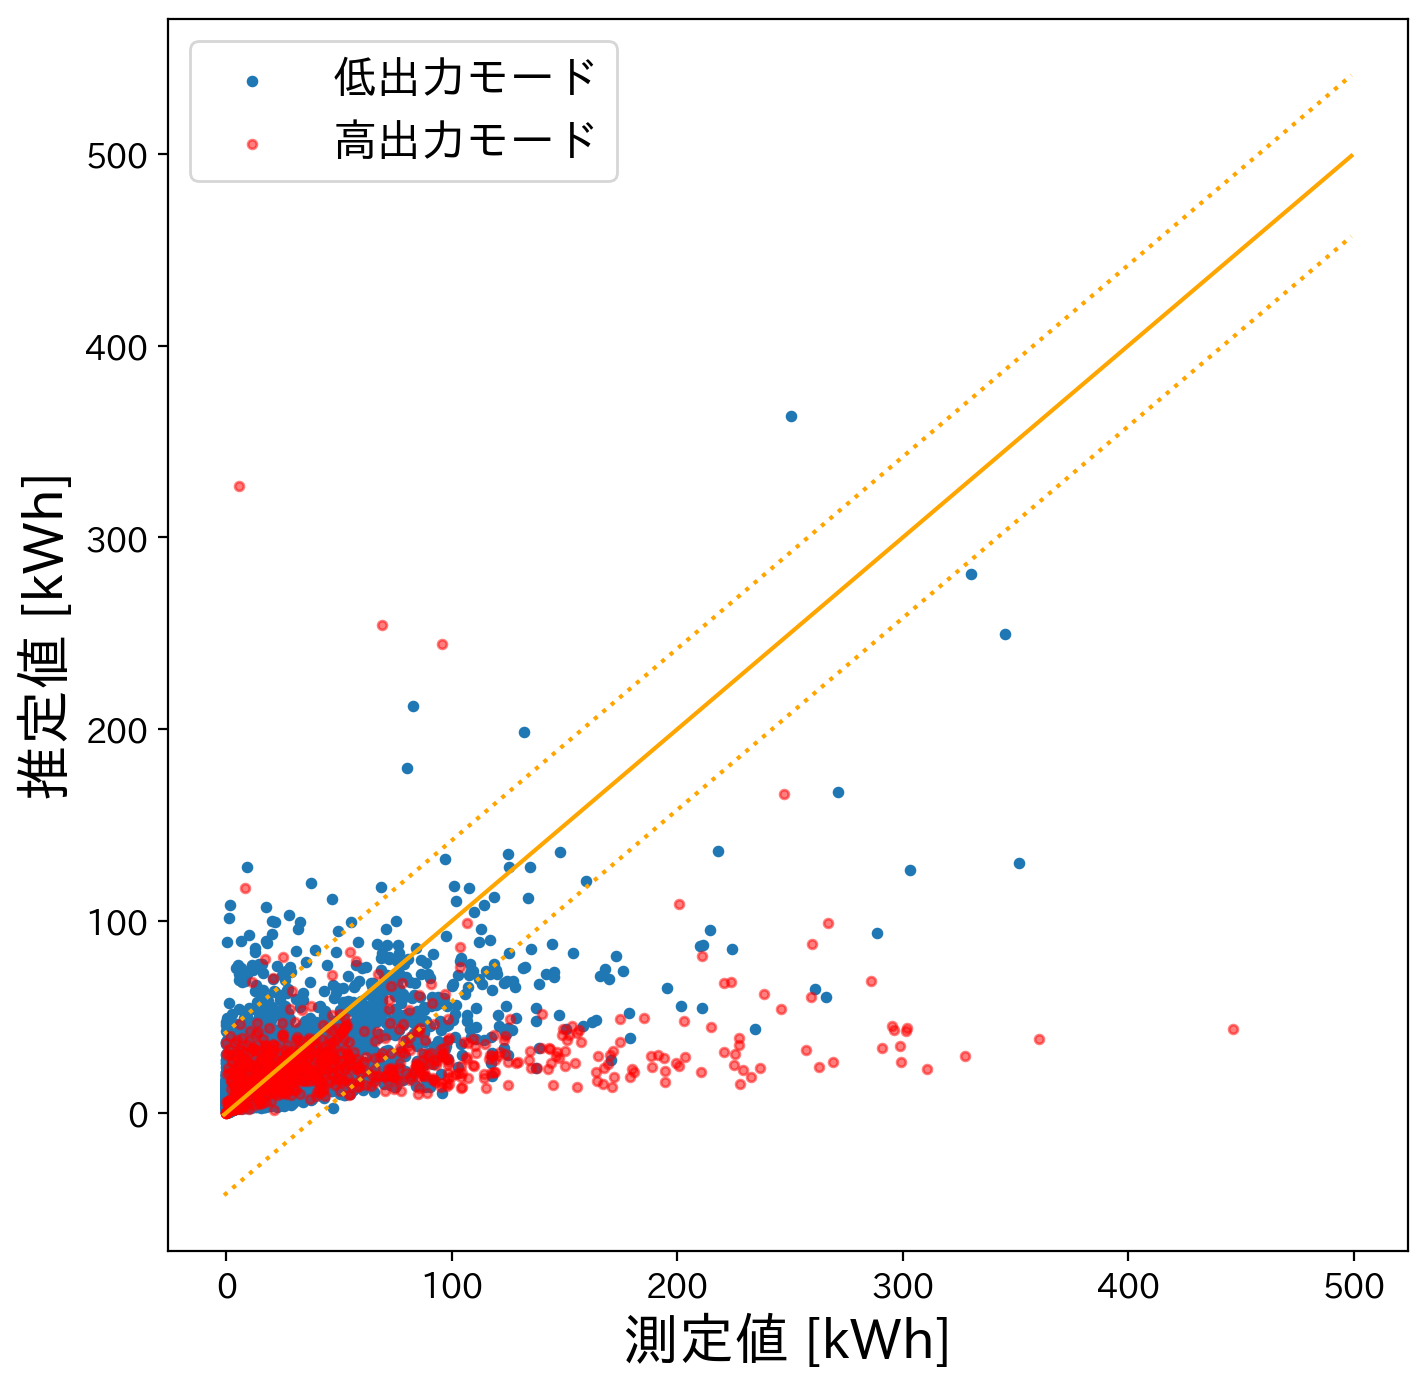

In [251]:
high_model = df_result[df_result['DROP_TIME'] != 0]
low_model = df_result[df_result['DROP_TIME'] == 0]
rmse = sqrt(mean_squared_error(df_result['Real_Wh'], df_result['Pred_Wh']))

plt.figure(figsize=(8, 8),dpi=200)
x = np.arange(-1, 500, 1)
y1 = x
plt.plot(x, y1, color='orange')
plt.plot(x, y1+2*rmse, color='orange', linestyle=':')
plt.plot(x, y1-2*rmse, color='orange', linestyle=':')

plt.scatter(low_model['Real_Wh'],low_model['Pred_Wh'],s=10,label='低出力モード')
plt.scatter(high_model['Real_Wh'],high_model['Pred_Wh'],s=10,c='r',alpha=0.5,label='高出力モード')

plt.xlabel('測定値 [kWh]',fontsize=20)
plt.ylabel('推定値 [kWh]',fontsize=20)
plt.legend(loc='upper left',fontsize=16)
plt.tick_params(labelsize=12)

plt.show()

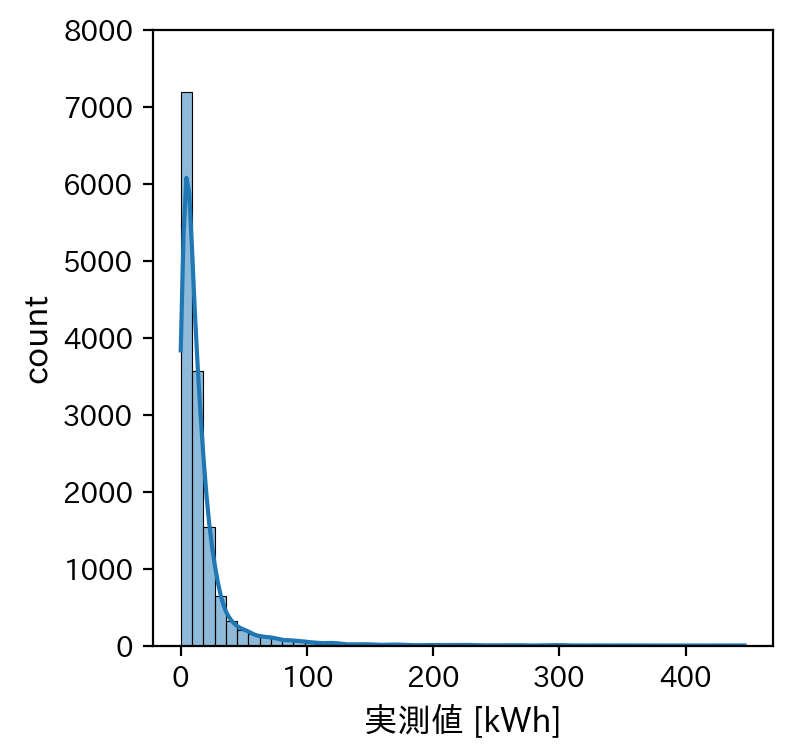

In [252]:
plt.figure(figsize=(4, 4),dpi=200)
sns.histplot(df_result['Real_Wh'], kde=True, bins=50)
plt.xlabel('実測値 [kWh]',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.ylim(0,8000)
plt.show()

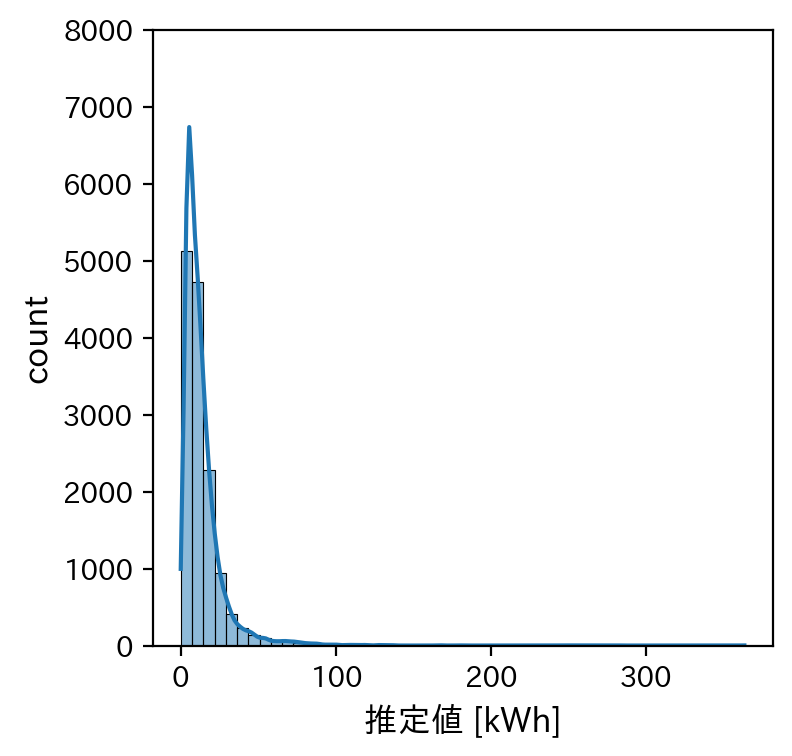

In [253]:
plt.figure(figsize=(4, 4),dpi=200)
sns.histplot(df_result['Pred_Wh'], kde=True, bins=50)
plt.xlabel('推定値 [kWh]',fontsize=12)
plt.ylabel('count',fontsize=12)
plt.ylim(0,8000)
plt.show()

In [254]:
print('実測値平均:',df_result['Real_Wh'].mean(),'実測値分散:',df_result['Real_Wh'].var())
print('推定値平均:',df_result['Pred_Wh'].mean(),'推定値分散:',df_result['Pred_Wh'].var())

実測値平均: 15.957200083400766 実測値分散: 667.6596219452024
推定値平均: 13.589427631254535 推定値分散: 205.34573778760284


In [255]:
print('実測値αβ:',calculate_alpha_beta(df_result['Real_Wh'].mean(),df_result['Real_Wh'].var()))
print('推定値αβ:',calculate_alpha_beta(df_result['Pred_Wh'].mean(),df_result['Pred_Wh'].var()))

実測値αβ: (41.8406498919397, 0.3813803113625825)
推定値αβ: (15.110698063200616, 0.8993249401461564)
